In [1]:
%matplotlib inline

import sys
sys.path.append('../src/')

import warnings
warnings.filterwarnings('ignore')

import cv2
import torch
import wider_dataset
import choke_point_dataset

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from benchmark.models import Detector
from benchmark.core import TsvHandle, run_detection, run_detection_video
from benchmark.stats import calc_precision_recall, calc_ap

# https://github.com/AyushExel/ml4face-detection/blob/master/Final-Face%20Detection%20Notebook.ipynb
# https://learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/
import dlib

# Dlib HoG Image detection

In [2]:
train, test, validation = tfds.load('wider_dataset', split=['train', 'test', 'validation'])
data = validation

In [3]:
class DlibHogDetector(Detector):
    def __init__(self):
        self.detector = dlib.get_frontal_face_detector()
        
    def detect(self, image):
        boxes = []
        confidence = []
        
        dets, scores, idx = self.detector.run(image, 1, -1)
        for i, d in enumerate(dets):
            if scores[i] > 0:
                x = d.left()
                y = d.top()
                x1 = d.right()
                y1 = d.bottom()
                
                boxes.append([x, y, x1, y1])
                confidence.append(scores[i])
        
        return boxes, confidence
    
dlib_hog = DlibHogDetector()

In [4]:
with TsvHandle('hog') as tsv:
    path, ap_path, load_path, meta_path = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = dlib_hog,
        cv2_filter = cv2.COLOR_RGB2GRAY
    )

print("")
print(path)
print(ap_path)
print(load_path)
print(meta_path)

Running detection
[====================] 100% [3226/3226]
./results/hog-20220618-151109.tsv
./results/hog-20220618-151109-ap.tsv
./results/hog-20220618-151109-load.tsv
./results/hog-20220618-151109-metadata.tsv


In [5]:
with TsvHandle('hog_filtered') as tsv:
    path_filtered, ap_path_filtered, load_path_filtered, meta_path_filtered = run_detection(
        tsv_handle = tsv, 
        samples = data, 
        detector = dlib_hog,
        filter_area = 2000
    )

print("")
print(path_filtered)
print(ap_path_filtered)
print(load_path_filtered)
print(meta_path_filtered)

Running detection
[====================] 100% [3226/3226]
./results/hog_filtered-20220618-152936.tsv
./results/hog_filtered-20220618-152936-ap.tsv
./results/hog_filtered-20220618-152936-load.tsv
./results/hog_filtered-20220618-152936-metadata.tsv


# Results

In [6]:
df = pd.read_csv(path, sep='\t', header=0, parse_dates=["Timestamp"])
df_filtered = pd.read_csv(path_filtered, sep='\t', header=0, parse_dates=["Timestamp"])

df_ap = pd.read_csv(ap_path, sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_ap_filtered = pd.read_csv(ap_path_filtered, sep='\t', header=0)
df_ap_filtered = df_ap_filtered.sort_values(by=['Confidence'], ignore_index=True, ascending=False)

df_load = pd.read_csv(load_path, sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv(meta_path, sep='\t', header=0)

In [7]:
df_meta

,Python,CPU,GPUs
0,3.8.13.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [8]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-06-18 15:11:09.655970,0.5,5766959104
1,2022-06-18 15:11:21.065556,7.7,5320921088
2,2022-06-18 15:11:32.292556,7.9,5310066688
3,2022-06-18 15:11:43.502055,7.4,5314813952
4,2022-06-18 15:11:54.502557,8.4,5292584960
...,...,...,...
93,2022-06-18 15:28:30.398608,7.1,5577986048
94,2022-06-18 15:28:41.882608,7.8,5592178688
95,2022-06-18 15:28:53.418613,8.0,5605687296
96,2022-06-18 15:29:04.565611,7.4,5636112384


In [9]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

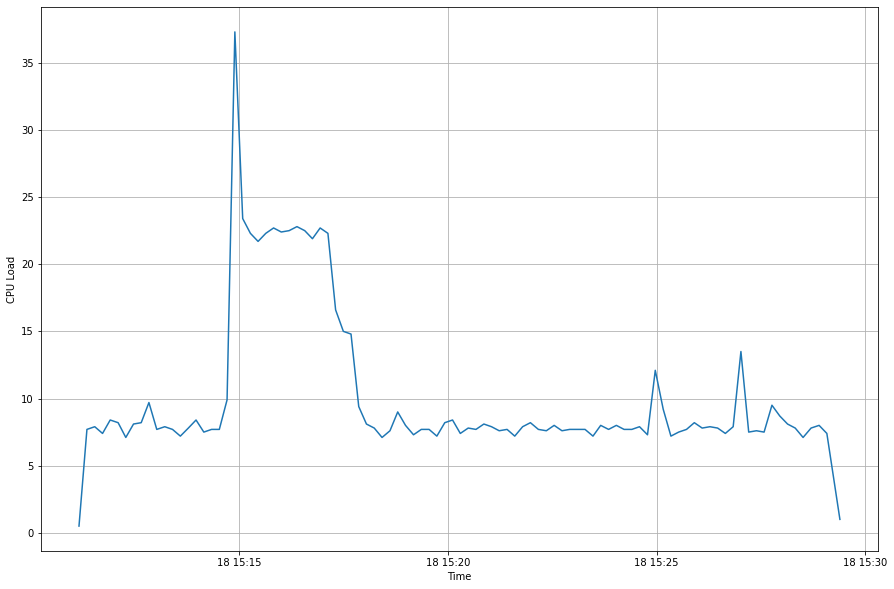

In [10]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

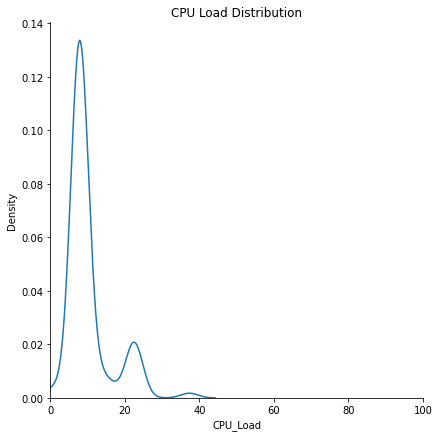

In [11]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

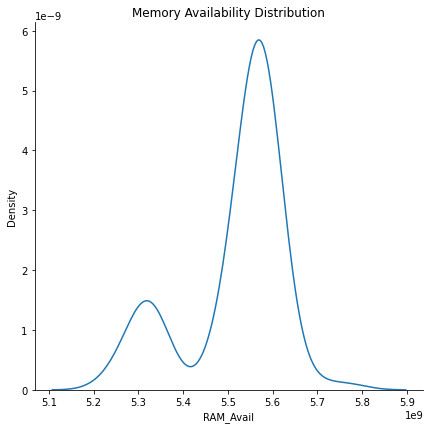

In [12]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [13]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-06-18 15:11:10.485055,254315900,1.0,0.375000,0.545455,"[0.5948354430379746, 0.7405478595979585, 0.545...",3,0,5,8,"[(763.0, 196.0, 852.0, 285.0), (175.0, 146.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-06-18 15:11:11.033556,543630800,0.0,0.000000,0.000000,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-06-18 15:11:11.289555,250202900,0.0,0.000000,0.000000,[],0,0,2,2,[],"[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-06-18 15:11:11.666057,283443600,1.0,0.016129,0.031746,[0.38556446637877856],1,0,61,62,"[(409.0, 462.0, 445.0, 498.0)]","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-06-18 15:11:11.897555,213491900,1.0,0.625000,0.769231,"[0.7106473293243721, 0.6142857142857143, 0.655...",5,0,3,8,"[(567.0, 78.0, 619.0, 130.0), (108.0, 94.0, 15...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-06-18 15:29:11.903108,540695500,0.0,0.000000,0.000000,[],0,0,1,1,[],"[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-06-18 15:29:12.452608,542561900,1.0,1.000000,1.000000,"[0.6332208337133997, 0.7342417500926955]",2,0,0,2,"[(703.0, 435.0, 792.0, 524.0), (325.0, 425.0, ...","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-06-18 15:29:12.812609,270671600,1.0,0.925926,0.961538,"[0.7692307692307693, 0.7533136966126657, 0.712...",25,0,2,27,"[(541.0, 382.0, 577.0, 418.0), (673.0, 494.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-06-18 15:29:13.036608,210730500,1.0,0.142857,0.250000,[0.7393767705382436],1,0,6,7,"[(745.0, 70.0, 781.0, 106.0)]","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [14]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,3.129709e+08,0.610326,0.412981,0.449864,1.715127,0.030068,10.593614,12.308741
std,1.248211e+08,0.483475,0.430983,0.431267,3.143750,0.194564,39.626654,39.822258
min,8.071690e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.403093e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,2.661903e+08,1.000000,0.250000,0.400000,1.000000,0.000000,1.000000,3.000000
75%,3.612070e+08,1.000000,1.000000,1.000000,2.000000,0.000000,6.000000,9.000000
max,2.033058e+09,1.000000,1.000000,1.000000,37.000000,4.000000,709.000000,709.000000


In [15]:
speed = df['Speed'].div(1e6).round(2)
speed.describe()

count    3226.000000
mean      312.970958
std       124.821197
min        80.720000
25%       240.312500
50%       266.190000
75%       361.205000
max      2033.060000
Name: Speed, dtype: float64

### Generate Precision/Recall columns

In [16]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()
df_ap = calc_precision_recall(df_ap, all_gts)

df_ap

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,3.858155,True,True,False,1.000000,0.000025,1.000000,0.000025,0.000000,0.000000
1,3.639372,True,True,False,1.000000,0.000050,1.000000,0.000050,0.000000,0.000000
2,3.441044,True,True,False,1.000000,0.000076,1.000000,0.000076,0.000000,0.000000
3,3.384986,True,True,False,1.000000,0.000101,1.000000,0.000101,0.000000,0.000000
4,3.346881,True,True,False,1.000000,0.000126,1.000000,0.000126,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
5625,0.000612,True,True,False,0.983114,0.139292,0.958052,0.135741,0.229115,0.032462
5626,0.000315,True,True,False,0.983117,0.139317,0.958059,0.135766,0.229074,0.032462
5627,0.000197,True,True,True,0.983120,0.139342,0.958067,0.135791,0.229211,0.032487
5628,0.000124,False,False,False,0.982945,0.139342,0.957897,0.135791,0.229170,0.032487


In [17]:
all_gts_filtered = df_filtered['Positives'].sum() + df_filtered['Negatives'].sum()
df_ap_filtered = calc_precision_recall(df_ap_filtered, all_gts_filtered)

df_ap_filtered

,Confidence,TP_FP@25,TP_FP@50,TP_FP@75,Precision@25,Recall@25,Precision@50,Recall@50,Precision@75,Recall@75
0,3.857351,True,True,False,1.000000,0.000140,1.000000,0.000140,0.000000,0.000000
1,3.609919,True,True,False,1.000000,0.000281,1.000000,0.000281,0.000000,0.000000
2,3.486799,True,True,False,1.000000,0.000421,1.000000,0.000421,0.000000,0.000000
3,3.479810,True,True,False,1.000000,0.000562,1.000000,0.000562,0.000000,0.000000
4,3.462434,True,True,False,1.000000,0.000702,1.000000,0.000702,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
3874,0.008583,True,False,False,0.988645,0.537911,0.956903,0.520640,0.206710,0.112468
3875,0.008506,True,True,False,0.988648,0.538051,0.956914,0.520781,0.206656,0.112468
3876,0.004545,True,True,False,0.988651,0.538192,0.956925,0.520921,0.206603,0.112468
3877,0.003650,True,True,False,0.988654,0.538332,0.956937,0.521061,0.206550,0.112468


In [18]:
def plot_pr(df_data, title):
    ap = calc_ap(df_data['Precision@25'], df_data['Recall@25'])
    plt.plot(df_data['Recall@25'], df_data['Precision@25'], color='darkcyan', lw=3, label="AP@0.25=%.2f" % ap)
    plt.axvline(x = df_data['Recall@25'][df_data.index[-1]], ymax=df_data['Precision@25'][df_data.index[-1]], color = 'darkcyan')
    
    ap = calc_ap(df_data['Precision@50'], df_data['Recall@50'])
    plt.plot(df_data['Recall@50'], df_data['Precision@50'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
    plt.axvline(x = df_data['Recall@50'][df_data.index[-1]], ymax=df_data['Precision@50'][df_data.index[-1]], color = 'darkorange')
    
    ap = calc_ap(df_data['Precision@75'], df_data['Recall@75'])
    plt.plot(df_data['Recall@75'], df_data['Precision@75'], color='mediumorchid', lw=3, label="AP@0.75=%.2f" % ap)
    plt.axvline(x = df_data['Recall@75'][df_data.index[-1]], ymax=df_data['Precision@75'][df_data.index[-1]], color = 'mediumorchid')
    
    plt.xlim(0, 1.00)
    plt.ylim(0, 1.00)

    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower right", prop={'size': 16})
    plt.grid(True)

    plt.show()

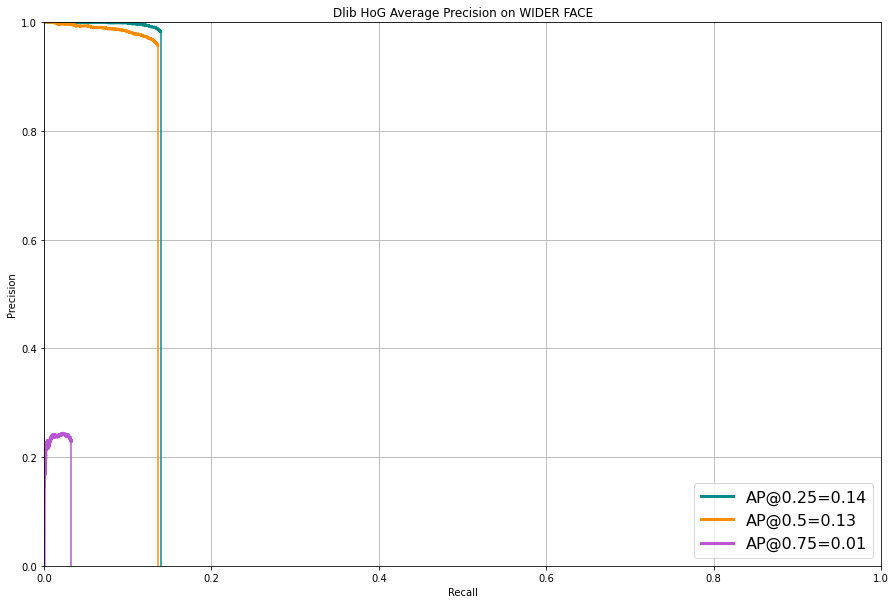

In [19]:
plot_pr(df_ap, 'Dlib HoG Average Precision on WIDER FACE')

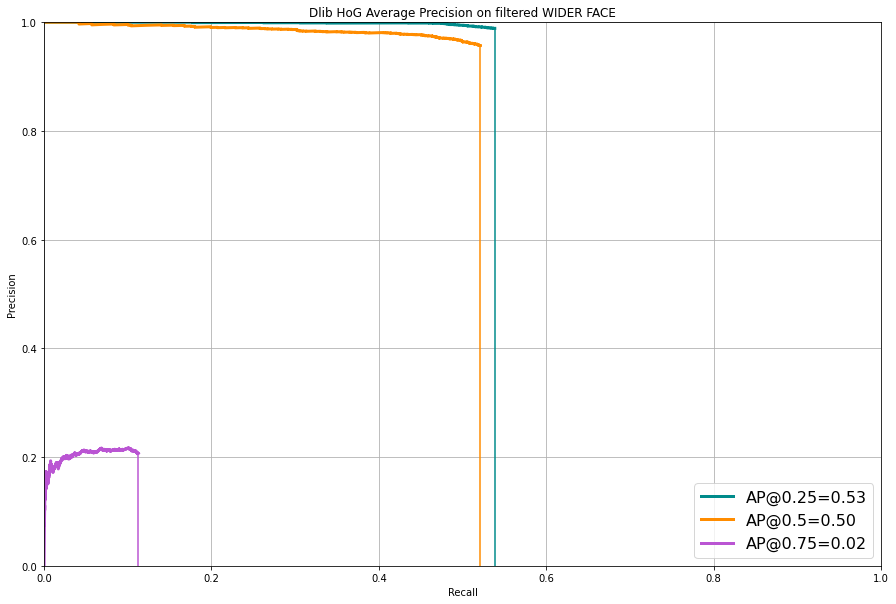

In [20]:
plot_pr(df_ap_filtered, 'Dlib HoG Average Precision on filtered WIDER FACE')

# Dlib HoG Video detection

In [21]:
test = tfds.load('choke_point', split=['test'])

In [22]:
data = test[0]

In [23]:
class DlibHogDetector(Detector):
    def __init__(self):
        self.detector = dlib.get_frontal_face_detector()
        
    def detect(self, image):
        boxes = []
        confidence = []
        
        dets, scores, idx = self.detector.run(image, 1, -1)
        for i, d in enumerate(dets):
            if scores[i] > 0:
                x = d.left()
                y = d.top()
                x1 = d.right()
                y1 = d.bottom()
                
                boxes.append([x, y, x1, y1])
                confidence.append(scores[i])
        
        return boxes, confidence
    
dlib_hog = DlibHogDetector()

In [24]:
stt_ious, detection_percentages, mean_confidences, mean_inference_times = run_detection_video(
    samples=data, 
    detector=dlib_hog,
    results_folder="hog",
    cv2_filter = cv2.COLOR_RGB2GRAY,
    save_videos=True
)

Frames: [====================] 100% [164/164], Videos: [216/216]

In [25]:
print("Mean Video STT-IOU: {0:.2f}".format(np.mean(stt_ious)))
print("Mean detection percentage of faces in all videos: {:.2f}".format(np.mean(detection_percentages)))
print("Mean confidence of boxes in all videos: {:.2f}".format(np.mean(mean_confidences)))
print("Mean inference time for all frames: {:.2f}ms".format(np.mean(mean_inference_times) / 1e+6))

Mean Video STT-IOU: 0.68
Mean detection percentage of faces in all videos: 74.28
Mean confidence of boxes in all videos: 1.13
Mean inference time for all frames: 175.03ms
